# Libraries & Custom functions

### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm

# Ignore UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
############################################################### Functions for Part 1 b) ###############################################################

def BCE_Loss(y_true, y_hat):
    if y_true == y_hat:
        return torch.tensor(0.)

    return -1 * (y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))


def ForwardPass(X, W, b = 0):

    z1 = torch.matmul(X, W[0].T) + b
    a1 = F.relu(z1)

    z2 = torch.matmul(a1, W[1].T) + b
    a2 = F.leaky_relu(z2, negative_slope = 0.01)

    z3 = torch.matmul(a2, W[2].T) + b
    a3 = F.sigmoid(z3)

    return a3, a2, a1


def BackwardPass(X, a1, a2, a3, y_true, W):

    # Partial derivative of the loss function with respect to the prediction
    dL_da3 = -1 * (y_true / a3 - (1 - y_true) / (1 - a3)) if y_true != a3 else torch.tensor([0.])
    # Partial derivative of the loss function with respect to z3, using the sigmoid derivative
    dL_dz3 = dL_da3 * (a3 * (1 - a3))
    # Partial derivative of the loss function with respect to the weights of the connections between the second hidden layer and the output layer
    dL_dW3 = torch.matmul(dL_dz3.T, a2)

    # Partial derivative of the loss function with respect to the activation values from the second hidden layer
    dL_da2 = torch.matmul(dL_dz3, W[2])
    # Partial derivative of the loss function with respect to z2, using the Leaky ReLU derivative
    dL_dz2 = torch.where(a2 >= 0, dL_da2, 0.01 * dL_da2)
    # Partial derivative of the loss function with respect to the weights of the connections between the first and second hidden layers
    dL_dW2 = torch.matmul(dL_dz2.T, a1)

    # Partial derivative of the loss function with respect to the activation values from the first hidden layer
    dL_da1 = torch.matmul(dL_dz2, W[1])
    # Partial derivative of the loss function with respect to z2, using the ReLU derivative
    dL_dz1 = torch.where(a1 >= 0, dL_da1, 0.0 * dL_da1)
    # Partial derivative of the loss function with respect to the weights of the connections between the input layer and the first hidden layers
    dL_dW1 = torch.matmul(dL_dz1.T, X)

    return dL_dW1, dL_dW2, dL_dW3


def StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr):
    # Update weights using SGD
    W[0] -= lr * dL_dW1
    W[1] -= lr * dL_dW2
    W[2] -= lr * dL_dW3

    return W


############################################################### Functions for Part 1 c) and d) ###############################################################

# Define a function to display a batch of images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Fix the missing closing parenthesis
    plt.show()


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


class NeuralNetwork_Exercise1_c(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 256)  # Input size for MNIST is 28x28=784
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 10)   # 10 output classes for Fashion-MNIST

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define a more complex neural network
class NeuralNetwork_Exercise1_d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = torch.nn.Linear(784, 256)
        self.fc_128_256 = torch.nn.Linear(128, 256)
        self.fc_256_512 = torch.nn.Linear(256, 512)
        self.fc_128_128 = torch.nn.Linear(128, 128)
        self.fc_256_256 = torch.nn.Linear(256, 256)
        self.fc_512_512 = torch.nn.Linear(512, 512)
        self.fc_512_1024 = torch.nn.Linear(512, 1024)
        self.fc_1024_1024 = torch.nn.Linear(1024, 1024)
        self.fc_1024_2048 = torch.nn.Linear(1024, 2048)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_2048_2048 = torch.nn.Linear(2048, 2048)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(256, 128)
        self.output_layer = torch.nn.Linear(128, 10)
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.batch_norm256(self.input_layer(x)))
        x = self.relu(self.batch_norm128(self.fc_256_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_128_128(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_128_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_256_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm1024(self.fc_512_1024(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm1024(self.fc_1024_1024(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm1024(self.fc_1024_1024(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm1024(self.fc_1024_1024(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm1024(self.fc_1024_1024(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm1024(self.fc_1024_1024(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_1024_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm512(self.fc_512_512(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_512_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm256(self.fc_256_256(x)))
        x = self.dropout_40(x)
        x = self.relu(self.batch_norm128(self.fc_256_128(x)))
        x = self.output_layer(x)
        return x


def train(model, train_loader, optimizer, loss_func, epochs, device, **kwargs):

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('Training phase...')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total = len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} ')

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print()
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist


def test(model, test_loader, loss_func, device):

    model.eval()

    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels).item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    print(f"Cross-Entropy on test set: {test_loss:.4f}")
    print(f"Accuracy on test set: {test_acc:.2f}%")

    return test_loss, test_acc

# Exercise 1

### Exercise 1. (A)

**Backpropagation** and **gradient descent** are like a dynamic duo in training deep neural networks (DNNs).

**Backpropagation** is the process of updating the model's weights by calculating the gradient of the loss function with respect to the weights. It's all about figuring out how much each weight contributed to the error, layer by layer, starting from the output layer and working backward through the network. This info helps adjust the weights to minimize the error in future predictions.

Now, **gradient descent** is the optimization technique that works hand-in-hand with backpropagation. It's all about finding the minimum of the loss function. The gradient (derivative) of the loss with respect to the weights tells us the direction of the steepest increase. Gradient descent takes steps in the opposite direction to minimize the loss.

So, to sum it up, backpropagation fine-tunes the weights based on the error, and gradient descent guides this process by minimizing the error step by step. They team up to make our neural networks smarter!

#### References

 - https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/#:~:text=To%20put%20it%20plainly%2C%20gradient,gradient%20descent%20relies%20on%20backpropagation.

### Exercise 1. (B)

#### References
https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c

In [3]:
input_values = torch.tensor([[5., 4., 1., 3., 2.]])

y_true = torch.tensor([1.])

w1 = torch.tensor([[0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2]])

w2 = torch.tensor([[0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2]])

w3 = torch.tensor([[0.2, 0.2]])

W = list([w1, w2, w3])

In [4]:
a3, a2, a1 = ForwardPass(input_values, W)
loss = BCE_Loss(y_true, a3)

print("Predicted Output (a3):", a3.item())
print("Expected Output (y_true):", y_true.item())
print("Binary Cross-Entropy Loss:", loss.item())

Predicted Output (a3): 0.6726070046424866
Expected Output (y_true): 1.0
Binary Cross-Entropy Loss: 0.3965940773487091


In [5]:
dL_dW1, dL_dW2, dL_dW3 = BackwardPass(input_values, a1, a2, a3, y_true, W)

print("dL_dW1:", dL_dW1)
print("dL_dW2:", dL_dW2)
print("dL_dW3:", dL_dW3)

dL_dW1: tensor([[-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524]])
dL_dW2: tensor([[-0.1964, -0.1964, -0.1964],
        [-0.1964, -0.1964, -0.1964]])
dL_dW3: tensor([[-0.5893, -0.5893]])


In [6]:
W = StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr = 0.2)

print("Updated W1:", W[0])
print("Updated W2:", W[1])
print("Updated W3:", W[2])

Updated W1: tensor([[0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105]])
Updated W2: tensor([[0.2393, 0.2393, 0.2393],
        [0.2393, 0.2393, 0.2393]])
Updated W3: tensor([[0.3179, 0.3179]])


<h2>After updating your weights what do you observe? Explain why.</h2>
<p>After computing the loss and doing a backward pass, and given that all weights were initialized with the value 2, we can see that none of the weights changed. Tracing back the steps made, we can see that all partial derivatives with respect to all the weights have a value of 0, which corroborates the fact that none of the weight's values changed. These partial derivatives measure the weight's variation in order for the loss of the neural network to decrease. So, the question now becomes, why all partial derivatives with respect to all weights show that no variation in their values is required in order to decrease the loss? Well, that's because the loss is already at its minimum, which is zero. Looking at how the binary loss is computed, we see that both the expected value and predicted value are exactly the same value, one, meaning that our network predicted perfectly the target. So, this means that there's no more room for improvement, and that's why all partial derivatives with respect to the weights are zero, and as consequence, the weight matrices didn't change.</p>

### Exercise 1. (C)

#### References
https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4

#### Data Loader

In [7]:
# Define data preprocessing and loading / Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Data Visualization - Sample from the train_loader (size 64 - batch size)

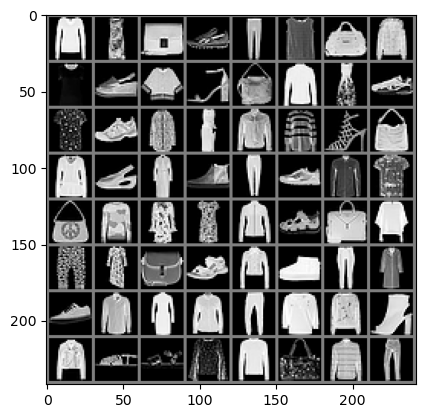

    2     3     8     7     1     0     8     4     0     5     4     5     8     6     3     7     6     5     4     3     4     6     5     8     6     5     4     7     1     7     6     0     8     2     3     3     4     5     8     6     1     3     8     5     4     9     1     4     7     6     3     6     1     2     6     5     4     5     5     6     2     8     6     1


In [8]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))


In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)

TrainLoader = torch.utils.data.DataLoader(trainset, batch_size = 2048, shuffle = True)
TestLoader = torch.utils.data.DataLoader(testset, batch_size = 2048, shuffle = False)

In [10]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork = NeuralNetwork_Exercise1_c().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr = 0.01)

Device: mps


In [11]:
train_loss_hist, train_acc_hist = train(NeuralNetwork, TrainLoader, optimizer, criterion, epochs = 32, device = device)

Epoch 1/32
Training phase...


  0%|          | 0/30 [00:00<?, ?it/s]

Loss = 0.5392  |  Accuracy = 66.83% | Batch ID = 30 : 100%|██████████| 30/30 [00:03<00:00,  9.67it/s]


Training Cross-Entropy Loss = 0.9257
Training Accuracy = 66.83%

Epoch 2/32
Training phase...


Loss = 0.4184  |  Accuracy = 82.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.92it/s]


Training Cross-Entropy Loss = 0.4672
Training Accuracy = 82.60%

Epoch 3/32
Training phase...


Loss = 0.3794  |  Accuracy = 85.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.56it/s]


Training Cross-Entropy Loss = 0.3840
Training Accuracy = 85.87%

Epoch 4/32
Training phase...


Loss = 0.2714  |  Accuracy = 86.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]


Training Cross-Entropy Loss = 0.3533
Training Accuracy = 86.87%

Epoch 5/32
Training phase...


Loss = 0.3482  |  Accuracy = 87.74% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.77it/s]


Training Cross-Entropy Loss = 0.3306
Training Accuracy = 87.74%

Epoch 6/32
Training phase...


Loss = 0.2509  |  Accuracy = 88.22% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.83it/s]


Training Cross-Entropy Loss = 0.3147
Training Accuracy = 88.22%

Epoch 7/32
Training phase...


Loss = 0.3001  |  Accuracy = 89.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.44it/s]


Training Cross-Entropy Loss = 0.2894
Training Accuracy = 89.30%

Epoch 8/32
Training phase...


Loss = 0.3094  |  Accuracy = 89.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Training Cross-Entropy Loss = 0.2847
Training Accuracy = 89.47%

Epoch 9/32
Training phase...


Loss = 0.2853  |  Accuracy = 89.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.90it/s]


Training Cross-Entropy Loss = 0.2748
Training Accuracy = 89.71%

Epoch 10/32
Training phase...


Loss = 0.2466  |  Accuracy = 90.17% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.48it/s]


Training Cross-Entropy Loss = 0.2607
Training Accuracy = 90.17%

Epoch 11/32
Training phase...


Loss = 0.2857  |  Accuracy = 90.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]


Training Cross-Entropy Loss = 0.2496
Training Accuracy = 90.62%

Epoch 12/32
Training phase...


Loss = 0.2545  |  Accuracy = 90.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.97it/s]


Training Cross-Entropy Loss = 0.2471
Training Accuracy = 90.66%

Epoch 13/32
Training phase...


Loss = 0.2346  |  Accuracy = 91.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.56it/s]


Training Cross-Entropy Loss = 0.2339
Training Accuracy = 91.16%

Epoch 14/32
Training phase...


Loss = 0.2586  |  Accuracy = 91.51% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.84it/s]


Training Cross-Entropy Loss = 0.2259
Training Accuracy = 91.51%

Epoch 15/32
Training phase...


Loss = 0.2278  |  Accuracy = 91.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Training Cross-Entropy Loss = 0.2273
Training Accuracy = 91.36%

Epoch 16/32
Training phase...


Loss = 0.1897  |  Accuracy = 91.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.94it/s]


Training Cross-Entropy Loss = 0.2223
Training Accuracy = 91.57%

Epoch 17/32
Training phase...


Loss = 0.1922  |  Accuracy = 92.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.51it/s]


Training Cross-Entropy Loss = 0.2097
Training Accuracy = 92.11%

Epoch 18/32
Training phase...


Loss = 0.1880  |  Accuracy = 92.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.97it/s]


Training Cross-Entropy Loss = 0.2013
Training Accuracy = 92.41%

Epoch 19/32
Training phase...


Loss = 0.1925  |  Accuracy = 92.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.87it/s]


Training Cross-Entropy Loss = 0.1923
Training Accuracy = 92.80%

Epoch 20/32
Training phase...


Loss = 0.2518  |  Accuracy = 92.81% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.60it/s]


Training Cross-Entropy Loss = 0.1905
Training Accuracy = 92.81%

Epoch 21/32
Training phase...


Loss = 0.2424  |  Accuracy = 92.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.92it/s]


Training Cross-Entropy Loss = 0.1968
Training Accuracy = 92.58%

Epoch 22/32
Training phase...


Loss = 0.1810  |  Accuracy = 93.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.83it/s]


Training Cross-Entropy Loss = 0.1784
Training Accuracy = 93.31%

Epoch 23/32
Training phase...


Loss = 0.2002  |  Accuracy = 93.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]


Training Cross-Entropy Loss = 0.1764
Training Accuracy = 93.23%

Epoch 24/32
Training phase...


Loss = 0.2051  |  Accuracy = 92.84% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.60it/s]


Training Cross-Entropy Loss = 0.1874
Training Accuracy = 92.84%

Epoch 25/32
Training phase...


Loss = 0.1534  |  Accuracy = 93.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.94it/s]


Training Cross-Entropy Loss = 0.1699
Training Accuracy = 93.47%

Epoch 26/32
Training phase...


Loss = 0.1891  |  Accuracy = 93.96% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.80it/s]


Training Cross-Entropy Loss = 0.1602
Training Accuracy = 93.96%

Epoch 27/32
Training phase...


Loss = 0.1722  |  Accuracy = 94.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.59it/s]


Training Cross-Entropy Loss = 0.1548
Training Accuracy = 94.10%

Epoch 28/32
Training phase...


Loss = 0.1450  |  Accuracy = 93.97% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.95it/s]


Training Cross-Entropy Loss = 0.1587
Training Accuracy = 93.97%

Epoch 29/32
Training phase...


Loss = 0.1490  |  Accuracy = 94.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.98it/s]


Training Cross-Entropy Loss = 0.1513
Training Accuracy = 94.27%

Epoch 30/32
Training phase...


Loss = 0.1563  |  Accuracy = 94.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.39it/s]


Training Cross-Entropy Loss = 0.1505
Training Accuracy = 94.36%

Epoch 31/32
Training phase...


Loss = 0.1393  |  Accuracy = 94.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]


Training Cross-Entropy Loss = 0.1493
Training Accuracy = 94.34%

Epoch 32/32
Training phase...


Loss = 0.1486  |  Accuracy = 94.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:02<00:00, 10.95it/s]

Training Cross-Entropy Loss = 0.1414
Training Accuracy = 94.64%

Cross-Entropy on training set:  0.1414
Accuracy on training set:       94.64%


In [12]:
test_loss, test_acc = test(NeuralNetwork, TestLoader, criterion, device)

Cross-Entropy on test set: 0.4373
Accuracy on test set: 88.37%


## Exercise 1, d) 

To improve the previous feedforward neural network for the Fashion-MNIST classification task, we can make the following changes:

**Increase Network Complexity**: We can add more hidden layers and neurons to increase the network's capacity to learn complex patterns in the data.

**Use Different Activation Function**: Instead of using ReLU (Rectified Linear Unit) activation, we can try a different activation function like Leaky ReLU, which might help with training.

**Regularization Techniques**: To prevent overfitting, we can add dropout layers and L2 regularization to the network.

**Batch Normalization**: Applying batch normalization can help stabilize and speed up training.

In [16]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork_complex = NeuralNetwork_Exercise1_d().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNetwork_complex.parameters(), lr = 0.0001, weight_decay = 0.001)  # L2 regularization

Device: mps


In [17]:
train_loss_hist, train_acc_hist = train(NeuralNetwork_complex, TrainLoader, optimizer, criterion, epochs = 512, device = device)

Epoch 1/512
Training phase...


Loss = 2.3862  |  Accuracy = 10.01% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.3550
Training Accuracy = 10.01%

Epoch 2/512
Training phase...


Loss = 2.3554  |  Accuracy = 10.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 2.3392
Training Accuracy = 10.19%

Epoch 3/512
Training phase...


Loss = 2.3326  |  Accuracy = 10.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.3275
Training Accuracy = 10.07%

Epoch 4/512
Training phase...


Loss = 2.3208  |  Accuracy = 10.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 2.3249
Training Accuracy = 10.10%

Epoch 5/512
Training phase...


Loss = 2.3288  |  Accuracy = 10.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.05it/s]


Training Cross-Entropy Loss = 2.3198
Training Accuracy = 10.10%

Epoch 6/512
Training phase...


Loss = 2.3287  |  Accuracy = 10.02% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 2.3160
Training Accuracy = 10.02%

Epoch 7/512
Training phase...


Loss = 2.3288  |  Accuracy = 10.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Training Cross-Entropy Loss = 2.3147
Training Accuracy = 10.20%

Epoch 8/512
Training phase...


Loss = 2.2904  |  Accuracy = 10.43% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 2.3108
Training Accuracy = 10.43%

Epoch 9/512
Training phase...


Loss = 2.3066  |  Accuracy = 10.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.3106
Training Accuracy = 10.45%

Epoch 10/512
Training phase...


Loss = 2.3254  |  Accuracy = 10.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.3063
Training Accuracy = 10.47%

Epoch 11/512
Training phase...


Loss = 2.3214  |  Accuracy = 10.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.3056
Training Accuracy = 10.68%

Epoch 12/512
Training phase...


Loss = 2.3102  |  Accuracy = 10.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 2.3053
Training Accuracy = 10.62%

Epoch 13/512
Training phase...


Loss = 2.2765  |  Accuracy = 10.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.3015
Training Accuracy = 10.46%

Epoch 14/512
Training phase...


Loss = 2.3121  |  Accuracy = 10.88% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2991
Training Accuracy = 10.88%

Epoch 15/512
Training phase...


Loss = 2.2834  |  Accuracy = 11.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 2.2955
Training Accuracy = 11.05%

Epoch 16/512
Training phase...


Loss = 2.3016  |  Accuracy = 11.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.2945
Training Accuracy = 11.11%

Epoch 17/512
Training phase...


Loss = 2.2950  |  Accuracy = 11.32% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.2902
Training Accuracy = 11.32%

Epoch 18/512
Training phase...


Loss = 2.2646  |  Accuracy = 11.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.2910
Training Accuracy = 11.41%

Epoch 19/512
Training phase...


Loss = 2.2842  |  Accuracy = 11.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 2.2866
Training Accuracy = 11.58%

Epoch 20/512
Training phase...


Loss = 2.2699  |  Accuracy = 11.51% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.2826
Training Accuracy = 11.51%

Epoch 21/512
Training phase...


Loss = 2.2838  |  Accuracy = 11.40% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.2827
Training Accuracy = 11.40%

Epoch 22/512
Training phase...


Loss = 2.2819  |  Accuracy = 11.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 2.2786
Training Accuracy = 11.54%

Epoch 23/512
Training phase...


Loss = 2.2706  |  Accuracy = 11.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.2763
Training Accuracy = 11.77%

Epoch 24/512
Training phase...


Loss = 2.2485  |  Accuracy = 12.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 2.2722
Training Accuracy = 12.23%

Epoch 25/512
Training phase...


Loss = 2.2562  |  Accuracy = 12.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2707
Training Accuracy = 12.19%

Epoch 26/512
Training phase...


Loss = 2.2638  |  Accuracy = 12.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 2.2679
Training Accuracy = 12.26%

Epoch 27/512
Training phase...


Loss = 2.2380  |  Accuracy = 12.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2680
Training Accuracy = 12.31%

Epoch 28/512
Training phase...


Loss = 2.2716  |  Accuracy = 12.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2633
Training Accuracy = 12.53%

Epoch 29/512
Training phase...


Loss = 2.2447  |  Accuracy = 12.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2625
Training Accuracy = 12.64%

Epoch 30/512
Training phase...


Loss = 2.2378  |  Accuracy = 12.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2583
Training Accuracy = 12.61%

Epoch 31/512
Training phase...


Loss = 2.2481  |  Accuracy = 12.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 2.2564
Training Accuracy = 12.66%

Epoch 32/512
Training phase...


Loss = 2.2410  |  Accuracy = 12.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.2535
Training Accuracy = 12.87%

Epoch 33/512
Training phase...


Loss = 2.2385  |  Accuracy = 13.01% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.2479
Training Accuracy = 13.01%

Epoch 34/512
Training phase...


Loss = 2.2436  |  Accuracy = 13.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 2.2467
Training Accuracy = 13.26%

Epoch 35/512
Training phase...


Loss = 2.2095  |  Accuracy = 13.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.2436
Training Accuracy = 13.20%

Epoch 36/512
Training phase...


Loss = 2.2200  |  Accuracy = 13.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2400
Training Accuracy = 13.70%

Epoch 37/512
Training phase...


Loss = 2.2133  |  Accuracy = 13.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2341
Training Accuracy = 13.87%

Epoch 38/512
Training phase...


Loss = 2.2127  |  Accuracy = 14.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 2.2340
Training Accuracy = 14.07%

Epoch 39/512
Training phase...


Loss = 2.2089  |  Accuracy = 14.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.2291
Training Accuracy = 14.00%

Epoch 40/512
Training phase...


Loss = 2.2004  |  Accuracy = 14.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.2251
Training Accuracy = 14.44%

Epoch 41/512
Training phase...


Loss = 2.2126  |  Accuracy = 14.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 2.2257
Training Accuracy = 14.44%

Epoch 42/512
Training phase...


Loss = 2.2352  |  Accuracy = 14.40% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.2214
Training Accuracy = 14.40%

Epoch 43/512
Training phase...


Loss = 2.2197  |  Accuracy = 15.21% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.2152
Training Accuracy = 15.21%

Epoch 44/512
Training phase...


Loss = 2.1778  |  Accuracy = 15.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.2098
Training Accuracy = 15.16%

Epoch 45/512
Training phase...


Loss = 2.1844  |  Accuracy = 15.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.11it/s]


Training Cross-Entropy Loss = 2.2065
Training Accuracy = 15.36%

Epoch 46/512
Training phase...


Loss = 2.1860  |  Accuracy = 15.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.2000
Training Accuracy = 15.55%

Epoch 47/512
Training phase...


Loss = 2.1671  |  Accuracy = 15.90% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.1908
Training Accuracy = 15.90%

Epoch 48/512
Training phase...


Loss = 2.1779  |  Accuracy = 16.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.1807
Training Accuracy = 16.31%

Epoch 49/512
Training phase...


Loss = 2.1662  |  Accuracy = 16.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 2.1739
Training Accuracy = 16.65%

Epoch 50/512
Training phase...


Loss = 2.1499  |  Accuracy = 16.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.1621
Training Accuracy = 16.89%

Epoch 51/512
Training phase...


Loss = 2.1348  |  Accuracy = 17.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.1560
Training Accuracy = 17.42%

Epoch 52/512
Training phase...


Loss = 2.1697  |  Accuracy = 17.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.1518
Training Accuracy = 17.26%

Epoch 53/512
Training phase...


Loss = 2.1290  |  Accuracy = 17.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 2.1448
Training Accuracy = 17.46%

Epoch 54/512
Training phase...


Loss = 2.1302  |  Accuracy = 17.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.1428
Training Accuracy = 17.48%

Epoch 55/512
Training phase...


Loss = 2.1415  |  Accuracy = 17.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.1375
Training Accuracy = 17.34%

Epoch 56/512
Training phase...


Loss = 2.1497  |  Accuracy = 17.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 2.1330
Training Accuracy = 17.70%

Epoch 57/512
Training phase...


Loss = 2.1490  |  Accuracy = 17.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.1271
Training Accuracy = 17.71%

Epoch 58/512
Training phase...


Loss = 2.0985  |  Accuracy = 17.99% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.92it/s]


Training Cross-Entropy Loss = 2.1196
Training Accuracy = 17.99%

Epoch 59/512
Training phase...


Loss = 2.1379  |  Accuracy = 17.99% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 2.1190
Training Accuracy = 17.99%

Epoch 60/512
Training phase...


Loss = 2.1262  |  Accuracy = 17.83% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


Training Cross-Entropy Loss = 2.1142
Training Accuracy = 17.83%

Epoch 61/512
Training phase...


Loss = 2.1052  |  Accuracy = 18.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 2.1060
Training Accuracy = 18.16%

Epoch 62/512
Training phase...


Loss = 2.1148  |  Accuracy = 18.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.1037
Training Accuracy = 18.19%

Epoch 63/512
Training phase...


Loss = 2.1070  |  Accuracy = 18.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.11it/s]


Training Cross-Entropy Loss = 2.1006
Training Accuracy = 18.28%

Epoch 64/512
Training phase...


Loss = 2.1090  |  Accuracy = 18.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.0943
Training Accuracy = 18.20%

Epoch 65/512
Training phase...


Loss = 2.0601  |  Accuracy = 18.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0917
Training Accuracy = 18.26%

Epoch 66/512
Training phase...


Loss = 2.0749  |  Accuracy = 18.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.0870
Training Accuracy = 18.54%

Epoch 67/512
Training phase...


Loss = 2.0695  |  Accuracy = 18.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 2.0802
Training Accuracy = 18.73%

Epoch 68/512
Training phase...


Loss = 2.1342  |  Accuracy = 18.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0823
Training Accuracy = 18.55%

Epoch 69/512
Training phase...


Loss = 2.0497  |  Accuracy = 18.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.0664
Training Accuracy = 18.71%

Epoch 70/512
Training phase...


Loss = 2.0790  |  Accuracy = 18.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0640
Training Accuracy = 18.62%

Epoch 71/512
Training phase...


Loss = 2.0425  |  Accuracy = 18.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 2.0566
Training Accuracy = 18.95%

Epoch 72/512
Training phase...


Loss = 2.0527  |  Accuracy = 18.88% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 2.0474
Training Accuracy = 18.88%

Epoch 73/512
Training phase...


Loss = 2.0015  |  Accuracy = 18.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0475
Training Accuracy = 18.68%

Epoch 74/512
Training phase...


Loss = 2.0165  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0363
Training Accuracy = 19.09%

Epoch 75/512
Training phase...


Loss = 2.0087  |  Accuracy = 19.17% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.05it/s]


Training Cross-Entropy Loss = 2.0287
Training Accuracy = 19.17%

Epoch 76/512
Training phase...


Loss = 2.0205  |  Accuracy = 18.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.16it/s]


Training Cross-Entropy Loss = 2.0212
Training Accuracy = 18.70%

Epoch 77/512
Training phase...


Loss = 2.0129  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 2.0164
Training Accuracy = 19.09%

Epoch 78/512
Training phase...


Loss = 1.9925  |  Accuracy = 18.98% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Training Cross-Entropy Loss = 2.0109
Training Accuracy = 18.98%

Epoch 79/512
Training phase...


Loss = 1.9950  |  Accuracy = 18.99% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9998
Training Accuracy = 18.99%

Epoch 80/512
Training phase...


Loss = 2.0093  |  Accuracy = 18.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9904
Training Accuracy = 18.85%

Epoch 81/512
Training phase...


Loss = 1.9795  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9793
Training Accuracy = 19.09%

Epoch 82/512
Training phase...


Loss = 1.9671  |  Accuracy = 19.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.9709
Training Accuracy = 19.14%

Epoch 83/512
Training phase...


Loss = 1.9567  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9668
Training Accuracy = 19.09%

Epoch 84/512
Training phase...


Loss = 1.9547  |  Accuracy = 19.21% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9561
Training Accuracy = 19.21%

Epoch 85/512
Training phase...


Loss = 1.9276  |  Accuracy = 19.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.05it/s]


Training Cross-Entropy Loss = 1.9448
Training Accuracy = 19.26%

Epoch 86/512
Training phase...


Loss = 1.9613  |  Accuracy = 19.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9422
Training Accuracy = 19.03%

Epoch 87/512
Training phase...


Loss = 1.9326  |  Accuracy = 19.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9454
Training Accuracy = 19.29%

Epoch 88/512
Training phase...


Loss = 1.9696  |  Accuracy = 19.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9432
Training Accuracy = 19.05%

Epoch 89/512
Training phase...


Loss = 1.9263  |  Accuracy = 19.08% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.9335
Training Accuracy = 19.08%

Epoch 90/512
Training phase...


Loss = 1.9447  |  Accuracy = 19.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9292
Training Accuracy = 19.07%

Epoch 91/512
Training phase...


Loss = 1.9395  |  Accuracy = 19.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9226
Training Accuracy = 19.23%

Epoch 92/512
Training phase...


Loss = 1.9191  |  Accuracy = 19.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.9453
Training Accuracy = 19.05%

Epoch 93/512
Training phase...


Loss = 1.8870  |  Accuracy = 19.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9138
Training Accuracy = 19.42%

Epoch 94/512
Training phase...


Loss = 1.9358  |  Accuracy = 19.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9074
Training Accuracy = 19.76%

Epoch 95/512
Training phase...


Loss = 1.9183  |  Accuracy = 19.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9064
Training Accuracy = 19.75%

Epoch 96/512
Training phase...


Loss = 1.9066  |  Accuracy = 19.72% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8951
Training Accuracy = 19.72%

Epoch 97/512
Training phase...


Loss = 1.9097  |  Accuracy = 19.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.8922
Training Accuracy = 19.80%

Epoch 98/512
Training phase...


Loss = 1.8714  |  Accuracy = 19.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.8894
Training Accuracy = 19.48%

Epoch 99/512
Training phase...


Loss = 1.8445  |  Accuracy = 19.83% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.8824
Training Accuracy = 19.83%

Epoch 100/512
Training phase...


Loss = 1.8921  |  Accuracy = 19.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8935
Training Accuracy = 19.63%

Epoch 101/512
Training phase...


Loss = 1.9905  |  Accuracy = 19.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9168
Training Accuracy = 19.64%

Epoch 102/512
Training phase...


Loss = 1.8890  |  Accuracy = 19.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9064
Training Accuracy = 19.82%

Epoch 103/512
Training phase...


Loss = 1.8994  |  Accuracy = 19.74% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8965
Training Accuracy = 19.74%

Epoch 104/512
Training phase...


Loss = 1.8798  |  Accuracy = 19.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.8943
Training Accuracy = 19.76%

Epoch 105/512
Training phase...


Loss = 1.9166  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9043
Training Accuracy = 19.93%

Epoch 106/512
Training phase...


Loss = 1.8944  |  Accuracy = 19.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8928
Training Accuracy = 19.87%

Epoch 107/512
Training phase...


Loss = 1.9530  |  Accuracy = 19.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9182
Training Accuracy = 19.73%

Epoch 108/512
Training phase...


Loss = 1.9042  |  Accuracy = 20.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9126
Training Accuracy = 20.16%

Epoch 109/512
Training phase...


Loss = 1.9250  |  Accuracy = 19.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9143
Training Accuracy = 19.80%

Epoch 110/512
Training phase...


Loss = 1.8601  |  Accuracy = 20.18% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9046
Training Accuracy = 20.18%

Epoch 111/512
Training phase...


Loss = 1.9276  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.8907
Training Accuracy = 19.93%

Epoch 112/512
Training phase...


Loss = 1.9206  |  Accuracy = 20.24% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8962
Training Accuracy = 20.24%

Epoch 113/512
Training phase...


Loss = 1.8827  |  Accuracy = 20.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9008
Training Accuracy = 20.14%

Epoch 114/512
Training phase...


Loss = 1.9064  |  Accuracy = 20.06% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.9109
Training Accuracy = 20.06%

Epoch 115/512
Training phase...


Loss = 1.8984  |  Accuracy = 20.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8995
Training Accuracy = 20.26%

Epoch 116/512
Training phase...


Loss = 1.8907  |  Accuracy = 20.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8954
Training Accuracy = 20.10%

Epoch 117/512
Training phase...


Loss = 1.9022  |  Accuracy = 19.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8776
Training Accuracy = 19.92%

Epoch 118/512
Training phase...


Loss = 1.8791  |  Accuracy = 20.18% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.8735
Training Accuracy = 20.18%

Epoch 119/512
Training phase...


Loss = 1.9193  |  Accuracy = 19.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9472
Training Accuracy = 19.60%

Epoch 120/512
Training phase...


Loss = 1.9163  |  Accuracy = 19.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9167
Training Accuracy = 19.92%

Epoch 121/512
Training phase...


Loss = 1.9000  |  Accuracy = 19.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.9158
Training Accuracy = 19.82%

Epoch 122/512
Training phase...


Loss = 1.9694  |  Accuracy = 19.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9085
Training Accuracy = 19.71%

Epoch 123/512
Training phase...


Loss = 1.9128  |  Accuracy = 19.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9040
Training Accuracy = 19.85%

Epoch 124/512
Training phase...


Loss = 1.9009  |  Accuracy = 20.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.8839
Training Accuracy = 20.07%

Epoch 125/512
Training phase...


Loss = 1.9221  |  Accuracy = 19.90% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8879
Training Accuracy = 19.90%

Epoch 126/512
Training phase...


Loss = 1.9829  |  Accuracy = 19.84% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 1.8899
Training Accuracy = 19.84%

Epoch 127/512
Training phase...


Loss = 1.8673  |  Accuracy = 19.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8829
Training Accuracy = 19.76%

Epoch 128/512
Training phase...


Loss = 1.8515  |  Accuracy = 20.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.8717
Training Accuracy = 20.07%

Epoch 129/512
Training phase...


Loss = 1.8796  |  Accuracy = 20.01% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.8776
Training Accuracy = 20.01%

Epoch 130/512
Training phase...


Loss = 1.8731  |  Accuracy = 19.97% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8607
Training Accuracy = 19.97%

Epoch 131/512
Training phase...


Loss = 1.8545  |  Accuracy = 19.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8672
Training Accuracy = 19.80%

Epoch 132/512
Training phase...


Loss = 1.8284  |  Accuracy = 20.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8583
Training Accuracy = 20.11%

Epoch 133/512
Training phase...


Loss = 1.8542  |  Accuracy = 19.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.8533
Training Accuracy = 19.73%

Epoch 134/512
Training phase...


Loss = 1.8518  |  Accuracy = 19.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8558
Training Accuracy = 19.80%

Epoch 135/512
Training phase...


Loss = 1.8936  |  Accuracy = 19.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8529
Training Accuracy = 19.53%

Epoch 136/512
Training phase...


Loss = 2.0111  |  Accuracy = 19.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9333
Training Accuracy = 19.23%

Epoch 137/512
Training phase...


Loss = 1.8952  |  Accuracy = 19.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9150
Training Accuracy = 19.68%

Epoch 138/512
Training phase...


Loss = 1.9049  |  Accuracy = 19.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8932
Training Accuracy = 19.68%

Epoch 139/512
Training phase...


Loss = 1.9037  |  Accuracy = 19.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8887
Training Accuracy = 19.64%

Epoch 140/512
Training phase...


Loss = 1.8758  |  Accuracy = 19.86% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.8846
Training Accuracy = 19.86%

Epoch 141/512
Training phase...


Loss = 1.8959  |  Accuracy = 19.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8809
Training Accuracy = 19.89%

Epoch 142/512
Training phase...


Loss = 1.8770  |  Accuracy = 19.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8825
Training Accuracy = 19.46%

Epoch 143/512
Training phase...


Loss = 1.8669  |  Accuracy = 19.59% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.8692
Training Accuracy = 19.59%

Epoch 144/512
Training phase...


Loss = 1.8478  |  Accuracy = 19.67% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.8558
Training Accuracy = 19.67%

Epoch 145/512
Training phase...


Loss = 1.9052  |  Accuracy = 19.69% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8524
Training Accuracy = 19.69%

Epoch 146/512
Training phase...


Loss = 1.8138  |  Accuracy = 19.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.8887
Training Accuracy = 19.45%

Epoch 147/512
Training phase...


Loss = 1.8217  |  Accuracy = 19.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.8610
Training Accuracy = 19.73%

Epoch 148/512
Training phase...


Loss = 1.8307  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8589
Training Accuracy = 19.93%

Epoch 149/512
Training phase...


Loss = 1.8498  |  Accuracy = 19.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8598
Training Accuracy = 19.57%

Epoch 150/512
Training phase...


Loss = 1.8990  |  Accuracy = 19.91% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8558
Training Accuracy = 19.91%

Epoch 151/512
Training phase...


Loss = 1.9300  |  Accuracy = 19.40% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.8988
Training Accuracy = 19.40%

Epoch 152/512
Training phase...


Loss = 1.8844  |  Accuracy = 19.50% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8830
Training Accuracy = 19.50%

Epoch 153/512
Training phase...


Loss = 1.8595  |  Accuracy = 19.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.8744
Training Accuracy = 19.62%

Epoch 154/512
Training phase...


Loss = 1.8888  |  Accuracy = 19.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8645
Training Accuracy = 19.56%

Epoch 155/512
Training phase...


Loss = 1.9045  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.9453
Training Accuracy = 19.09%

Epoch 156/512
Training phase...


Loss = 1.8496  |  Accuracy = 19.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8737
Training Accuracy = 19.85%

Epoch 157/512
Training phase...


Loss = 1.8792  |  Accuracy = 19.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8653
Training Accuracy = 19.46%

Epoch 158/512
Training phase...


Loss = 1.8491  |  Accuracy = 19.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Training Cross-Entropy Loss = 1.8741
Training Accuracy = 19.20%

Epoch 159/512
Training phase...


Loss = 1.8987  |  Accuracy = 19.17% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8808
Training Accuracy = 19.17%

Epoch 160/512
Training phase...


Loss = 1.8587  |  Accuracy = 19.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8753
Training Accuracy = 19.48%

Epoch 161/512
Training phase...


Loss = 1.8450  |  Accuracy = 19.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9020
Training Accuracy = 19.29%

Epoch 162/512
Training phase...


Loss = 1.9005  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9120
Training Accuracy = 19.09%

Epoch 163/512
Training phase...


Loss = 1.9319  |  Accuracy = 19.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8849
Training Accuracy = 19.28%

Epoch 164/512
Training phase...


Loss = 1.8803  |  Accuracy = 19.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8789
Training Accuracy = 19.55%

Epoch 165/512
Training phase...


Loss = 1.8363  |  Accuracy = 19.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.11it/s]


Training Cross-Entropy Loss = 1.8657
Training Accuracy = 19.57%

Epoch 166/512
Training phase...


Loss = 1.8306  |  Accuracy = 19.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8597
Training Accuracy = 19.77%

Epoch 167/512
Training phase...


Loss = 1.9425  |  Accuracy = 18.72% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 2.0179
Training Accuracy = 18.72%

Epoch 168/512
Training phase...


Loss = 1.8952  |  Accuracy = 19.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9338
Training Accuracy = 19.30%

Epoch 169/512
Training phase...


Loss = 1.8838  |  Accuracy = 19.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Training Cross-Entropy Loss = 1.8870
Training Accuracy = 19.48%

Epoch 170/512
Training phase...


Loss = 1.9173  |  Accuracy = 19.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8810
Training Accuracy = 19.36%

Epoch 171/512
Training phase...


Loss = 1.8871  |  Accuracy = 19.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8834
Training Accuracy = 19.58%

Epoch 172/512
Training phase...


Loss = 1.8975  |  Accuracy = 19.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8889
Training Accuracy = 19.39%

Epoch 173/512
Training phase...


Loss = 1.9166  |  Accuracy = 19.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9057
Training Accuracy = 19.36%

Epoch 174/512
Training phase...


Loss = 1.8668  |  Accuracy = 19.43% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8906
Training Accuracy = 19.43%

Epoch 175/512
Training phase...


Loss = 1.8823  |  Accuracy = 19.22% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8916
Training Accuracy = 19.22%

Epoch 176/512
Training phase...


Loss = 1.9124  |  Accuracy = 19.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8935
Training Accuracy = 19.52%

Epoch 177/512
Training phase...


Loss = 1.8684  |  Accuracy = 19.06% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.8907
Training Accuracy = 19.06%

Epoch 178/512
Training phase...


Loss = 1.8916  |  Accuracy = 19.35% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.16it/s]


Training Cross-Entropy Loss = 1.8882
Training Accuracy = 19.35%

Epoch 179/512
Training phase...


Loss = 1.8846  |  Accuracy = 19.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8882
Training Accuracy = 19.47%

Epoch 180/512
Training phase...


Loss = 1.8904  |  Accuracy = 19.50% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.8944
Training Accuracy = 19.50%

Epoch 181/512
Training phase...


Loss = 1.8545  |  Accuracy = 19.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8815
Training Accuracy = 19.53%

Epoch 182/512
Training phase...


Loss = 1.8476  |  Accuracy = 19.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8731
Training Accuracy = 19.38%

Epoch 183/512
Training phase...


Loss = 2.0528  |  Accuracy = 19.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8834
Training Accuracy = 19.23%

Epoch 184/512
Training phase...


Loss = 2.1525  |  Accuracy = 16.35% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 2.1943
Training Accuracy = 16.35%

Epoch 185/512
Training phase...


Loss = 2.0982  |  Accuracy = 16.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.1243
Training Accuracy = 16.23%

Epoch 186/512
Training phase...


Loss = 1.9998  |  Accuracy = 17.90% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.0470
Training Accuracy = 17.90%

Epoch 187/512
Training phase...


Loss = 1.9483  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9559
Training Accuracy = 19.09%

Epoch 188/512
Training phase...


Loss = 1.8881  |  Accuracy = 19.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9153
Training Accuracy = 19.62%

Epoch 189/512
Training phase...


Loss = 1.9018  |  Accuracy = 18.97% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8964
Training Accuracy = 18.97%

Epoch 190/512
Training phase...


Loss = 1.8618  |  Accuracy = 19.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8929
Training Accuracy = 19.19%

Epoch 191/512
Training phase...


Loss = 1.8728  |  Accuracy = 19.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.8846
Training Accuracy = 19.73%

Epoch 192/512
Training phase...


Loss = 1.8750  |  Accuracy = 19.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8865
Training Accuracy = 19.46%

Epoch 193/512
Training phase...


Loss = 1.8759  |  Accuracy = 19.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8805
Training Accuracy = 19.45%

Epoch 194/512
Training phase...


Loss = 1.9125  |  Accuracy = 19.24% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9094
Training Accuracy = 19.24%

Epoch 195/512
Training phase...


Loss = 1.8957  |  Accuracy = 19.01% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9001
Training Accuracy = 19.01%

Epoch 196/512
Training phase...


Loss = 1.8945  |  Accuracy = 19.40% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9003
Training Accuracy = 19.40%

Epoch 197/512
Training phase...


Loss = 1.9064  |  Accuracy = 19.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9010
Training Accuracy = 19.36%

Epoch 198/512
Training phase...


Loss = 1.8933  |  Accuracy = 19.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8976
Training Accuracy = 19.30%

Epoch 199/512
Training phase...


Loss = 1.8924  |  Accuracy = 19.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.8966
Training Accuracy = 19.14%

Epoch 200/512
Training phase...


Loss = 1.8683  |  Accuracy = 19.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.8942
Training Accuracy = 19.36%

Epoch 201/512
Training phase...


Loss = 1.8832  |  Accuracy = 19.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.8906
Training Accuracy = 19.76%

Epoch 202/512
Training phase...


Loss = 1.8297  |  Accuracy = 19.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.8969
Training Accuracy = 19.14%

Epoch 203/512
Training phase...


Loss = 1.8800  |  Accuracy = 19.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.8924
Training Accuracy = 19.28%

Epoch 204/512
Training phase...


Loss = 1.9036  |  Accuracy = 19.21% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.8932
Training Accuracy = 19.21%

Epoch 205/512
Training phase...


Loss = 2.0991  |  Accuracy = 18.84% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0032
Training Accuracy = 18.84%

Epoch 206/512
Training phase...


Loss = 2.0229  |  Accuracy = 18.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 2.0283
Training Accuracy = 18.28%

Epoch 207/512
Training phase...


Loss = 2.0354  |  Accuracy = 18.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.0169
Training Accuracy = 18.39%

Epoch 208/512
Training phase...


Loss = 1.9699  |  Accuracy = 18.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0161
Training Accuracy = 18.30%

Epoch 209/512
Training phase...


Loss = 2.0102  |  Accuracy = 19.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]


Training Cross-Entropy Loss = 1.9674
Training Accuracy = 19.20%

Epoch 210/512
Training phase...


Loss = 1.9507  |  Accuracy = 19.32% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9492
Training Accuracy = 19.32%

Epoch 211/512
Training phase...


Loss = 1.9315  |  Accuracy = 19.32% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9337
Training Accuracy = 19.32%

Epoch 212/512
Training phase...


Loss = 2.0570  |  Accuracy = 18.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0067
Training Accuracy = 18.60%

Epoch 213/512
Training phase...


Loss = 2.0458  |  Accuracy = 18.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 2.0146
Training Accuracy = 18.39%

Epoch 214/512
Training phase...


Loss = 1.9662  |  Accuracy = 18.86% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9969
Training Accuracy = 18.86%

Epoch 215/512
Training phase...


Loss = 1.9793  |  Accuracy = 19.37% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9768
Training Accuracy = 19.37%

Epoch 216/512
Training phase...


Loss = 1.9503  |  Accuracy = 19.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9578
Training Accuracy = 19.48%

Epoch 217/512
Training phase...


Loss = 1.9663  |  Accuracy = 19.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9554
Training Accuracy = 19.64%

Epoch 218/512
Training phase...


Loss = 2.0286  |  Accuracy = 19.50% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9506
Training Accuracy = 19.50%

Epoch 219/512
Training phase...


Loss = 1.9771  |  Accuracy = 19.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9531
Training Accuracy = 19.45%

Epoch 220/512
Training phase...


Loss = 1.9276  |  Accuracy = 19.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.11it/s]


Training Cross-Entropy Loss = 1.9482
Training Accuracy = 19.46%

Epoch 221/512
Training phase...


Loss = 1.9779  |  Accuracy = 19.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9477
Training Accuracy = 19.46%

Epoch 222/512
Training phase...


Loss = 1.9433  |  Accuracy = 19.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9371
Training Accuracy = 19.56%

Epoch 223/512
Training phase...


Loss = 1.9644  |  Accuracy = 19.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 1.9379
Training Accuracy = 19.54%

Epoch 224/512
Training phase...


Loss = 1.9528  |  Accuracy = 19.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9329
Training Accuracy = 19.47%

Epoch 225/512
Training phase...


Loss = 1.9259  |  Accuracy = 19.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9436
Training Accuracy = 19.52%

Epoch 226/512
Training phase...


Loss = 1.9214  |  Accuracy = 19.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9307
Training Accuracy = 19.60%

Epoch 227/512
Training phase...


Loss = 1.9507  |  Accuracy = 19.97% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9174
Training Accuracy = 19.97%

Epoch 228/512
Training phase...


Loss = 1.8410  |  Accuracy = 19.84% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.12it/s]


Training Cross-Entropy Loss = 1.9105
Training Accuracy = 19.84%

Epoch 229/512
Training phase...


Loss = 1.9925  |  Accuracy = 19.08% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9703
Training Accuracy = 19.08%

Epoch 230/512
Training phase...


Loss = 2.0208  |  Accuracy = 17.59% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 2.0456
Training Accuracy = 17.59%

Epoch 231/512
Training phase...


Loss = 2.0033  |  Accuracy = 18.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9989
Training Accuracy = 18.14%

Epoch 232/512
Training phase...


Loss = 1.9707  |  Accuracy = 18.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9807
Training Accuracy = 18.09%

Epoch 233/512
Training phase...


Loss = 1.9957  |  Accuracy = 17.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.0057
Training Accuracy = 17.70%

Epoch 234/512
Training phase...


Loss = 1.9533  |  Accuracy = 18.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9791
Training Accuracy = 18.00%

Epoch 235/512
Training phase...


Loss = 1.9608  |  Accuracy = 18.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9606
Training Accuracy = 18.52%

Epoch 236/512
Training phase...


Loss = 1.9012  |  Accuracy = 18.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9517
Training Accuracy = 18.55%

Epoch 237/512
Training phase...


Loss = 1.9217  |  Accuracy = 18.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9557
Training Accuracy = 18.44%

Epoch 238/512
Training phase...


Loss = 1.9183  |  Accuracy = 18.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9490
Training Accuracy = 18.55%

Epoch 239/512
Training phase...


Loss = 1.9345  |  Accuracy = 19.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9414
Training Accuracy = 19.11%

Epoch 240/512
Training phase...


Loss = 1.9405  |  Accuracy = 18.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9384
Training Accuracy = 18.95%

Epoch 241/512
Training phase...


Loss = 1.9654  |  Accuracy = 18.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9412
Training Accuracy = 18.70%

Epoch 242/512
Training phase...


Loss = 1.9057  |  Accuracy = 18.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 1.9397
Training Accuracy = 18.82%

Epoch 243/512
Training phase...


Loss = 1.9204  |  Accuracy = 18.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9390
Training Accuracy = 18.73%

Epoch 244/512
Training phase...


Loss = 1.9270  |  Accuracy = 18.81% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9468
Training Accuracy = 18.81%

Epoch 245/512
Training phase...


Loss = 1.9106  |  Accuracy = 18.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 1.9462
Training Accuracy = 18.65%

Epoch 246/512
Training phase...


Loss = 1.9466  |  Accuracy = 18.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9468
Training Accuracy = 18.60%

Epoch 247/512
Training phase...


Loss = 1.9205  |  Accuracy = 18.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9635
Training Accuracy = 18.62%

Epoch 248/512
Training phase...


Loss = 1.8992  |  Accuracy = 18.88% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9310
Training Accuracy = 18.88%

Epoch 249/512
Training phase...


Loss = 1.9298  |  Accuracy = 18.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Training Cross-Entropy Loss = 1.9387
Training Accuracy = 18.73%

Epoch 250/512
Training phase...


Loss = 1.9065  |  Accuracy = 18.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9338
Training Accuracy = 18.64%

Epoch 251/512
Training phase...


Loss = 1.9060  |  Accuracy = 19.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9095
Training Accuracy = 19.07%

Epoch 252/512
Training phase...


Loss = 1.9425  |  Accuracy = 19.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 1.9125
Training Accuracy = 19.39%

Epoch 253/512
Training phase...


Loss = 1.8973  |  Accuracy = 19.02% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]


Training Cross-Entropy Loss = 1.9103
Training Accuracy = 19.02%

Epoch 254/512
Training phase...


Loss = 1.9002  |  Accuracy = 19.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 1.9074
Training Accuracy = 19.45%

Epoch 255/512
Training phase...


Loss = 1.8843  |  Accuracy = 18.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 1.9103
Training Accuracy = 18.95%

Epoch 256/512
Training phase...


Loss = 1.8835  |  Accuracy = 19.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9111
Training Accuracy = 19.11%

Epoch 257/512
Training phase...


Loss = 1.9033  |  Accuracy = 19.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Training Cross-Entropy Loss = 1.9083
Training Accuracy = 19.28%

Epoch 258/512
Training phase...


Loss = 1.8981  |  Accuracy = 19.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 1.9105
Training Accuracy = 19.05%

Epoch 259/512
Training phase...


Loss = 1.8895  |  Accuracy = 18.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 1.9111
Training Accuracy = 18.95%

Epoch 260/512
Training phase...


Loss = 1.9412  |  Accuracy = 19.33% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Training Cross-Entropy Loss = 1.9150
Training Accuracy = 19.33%

Epoch 261/512
Training phase...


Loss = 1.8875  |  Accuracy = 19.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Training Cross-Entropy Loss = 1.9141
Training Accuracy = 19.14%

Epoch 262/512
Training phase...


Loss = 1.9346  |  Accuracy = 19.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Training Cross-Entropy Loss = 1.9159
Training Accuracy = 19.31%

Epoch 263/512
Training phase...


Loss = 1.8931  |  Accuracy = 19.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 1.9134
Training Accuracy = 19.39%

Epoch 264/512
Training phase...


Loss = 1.9178  |  Accuracy = 19.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


Training Cross-Entropy Loss = 1.9215
Training Accuracy = 19.23%

Epoch 265/512
Training phase...


Loss = 1.8964  |  Accuracy = 19.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 1.9172
Training Accuracy = 19.23%

Epoch 266/512
Training phase...


Loss = 1.8970  |  Accuracy = 18.98% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 1.9155
Training Accuracy = 18.98%

Epoch 267/512
Training phase...


Loss = 1.8964  |  Accuracy = 19.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Training Cross-Entropy Loss = 1.9157
Training Accuracy = 19.07%

Epoch 268/512
Training phase...


Loss = 1.9205  |  Accuracy = 19.24% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Training Cross-Entropy Loss = 1.9209
Training Accuracy = 19.24%

Epoch 269/512
Training phase...


Loss = 1.9053  |  Accuracy = 19.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9172
Training Accuracy = 19.27%

Epoch 270/512
Training phase...


Loss = 1.9241  |  Accuracy = 18.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9209
Training Accuracy = 18.95%

Epoch 271/512
Training phase...


Loss = 1.9121  |  Accuracy = 19.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Training Cross-Entropy Loss = 1.9176
Training Accuracy = 19.26%

Epoch 272/512
Training phase...


Loss = 1.8814  |  Accuracy = 19.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9147
Training Accuracy = 19.29%

Epoch 273/512
Training phase...


Loss = 1.8817  |  Accuracy = 19.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9161
Training Accuracy = 19.10%

Epoch 274/512
Training phase...


Loss = 1.8873  |  Accuracy = 19.13% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


Training Cross-Entropy Loss = 1.9162
Training Accuracy = 19.13%

Epoch 275/512
Training phase...


Loss = 1.9373  |  Accuracy = 18.88% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9164
Training Accuracy = 18.88%

Epoch 276/512
Training phase...


Loss = 1.9138  |  Accuracy = 19.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Training Cross-Entropy Loss = 1.9100
Training Accuracy = 19.34%

Epoch 277/512
Training phase...


Loss = 1.8959  |  Accuracy = 19.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9167
Training Accuracy = 19.11%

Epoch 278/512
Training phase...


Loss = 1.9203  |  Accuracy = 19.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9267
Training Accuracy = 19.20%

Epoch 279/512
Training phase...


Loss = 1.9211  |  Accuracy = 19.32% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Training Cross-Entropy Loss = 1.9296
Training Accuracy = 19.32%

Epoch 280/512
Training phase...


Loss = 1.9363  |  Accuracy = 18.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9331
Training Accuracy = 18.82%

Epoch 281/512
Training phase...


Loss = 1.8889  |  Accuracy = 19.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Training Cross-Entropy Loss = 1.9320
Training Accuracy = 19.09%

Epoch 282/512
Training phase...


Loss = 1.9475  |  Accuracy = 19.35% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.14it/s]


Training Cross-Entropy Loss = 1.9320
Training Accuracy = 19.35%

Epoch 283/512
Training phase...


Loss = 1.9260  |  Accuracy = 19.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9508
Training Accuracy = 19.07%

Epoch 284/512
Training phase...


Loss = 1.9294  |  Accuracy = 18.94% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9582
Training Accuracy = 18.94%

Epoch 285/512
Training phase...


Loss = 1.9503  |  Accuracy = 18.98% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.01it/s]


Training Cross-Entropy Loss = 1.9595
Training Accuracy = 18.98%

Epoch 286/512
Training phase...


Loss = 1.9085  |  Accuracy = 18.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Training Cross-Entropy Loss = 1.9563
Training Accuracy = 18.85%

Epoch 287/512
Training phase...


Loss = 1.9044  |  Accuracy = 19.08% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Training Cross-Entropy Loss = 1.9168
Training Accuracy = 19.08%

Epoch 288/512
Training phase...


Loss = 1.9044  |  Accuracy = 19.06% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Training Cross-Entropy Loss = 1.9092
Training Accuracy = 19.06%

Epoch 289/512
Training phase...


Loss = 1.9186  |  Accuracy = 18.91% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9130
Training Accuracy = 18.91%

Epoch 290/512
Training phase...


Loss = 1.9151  |  Accuracy = 19.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9083
Training Accuracy = 19.05%

Epoch 291/512
Training phase...


Loss = 1.9050  |  Accuracy = 19.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9130
Training Accuracy = 19.30%

Epoch 292/512
Training phase...


Loss = 1.9371  |  Accuracy = 19.33% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Training Cross-Entropy Loss = 1.9092
Training Accuracy = 19.33%

Epoch 293/512
Training phase...


Loss = 1.9192  |  Accuracy = 19.49% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.01it/s]


Training Cross-Entropy Loss = 1.9063
Training Accuracy = 19.49%

Epoch 294/512
Training phase...


Loss = 1.9253  |  Accuracy = 19.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Training Cross-Entropy Loss = 1.9092
Training Accuracy = 19.60%

Epoch 295/512
Training phase...


Loss = 1.8893  |  Accuracy = 19.18% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  5.00it/s]


Training Cross-Entropy Loss = 1.9100
Training Accuracy = 19.18%

Epoch 296/512
Training phase...


Loss = 1.9066  |  Accuracy = 19.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.94it/s]


Training Cross-Entropy Loss = 1.9066
Training Accuracy = 19.41%

Epoch 297/512
Training phase...


Loss = 1.8880  |  Accuracy = 19.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.93it/s]


Training Cross-Entropy Loss = 1.9089
Training Accuracy = 19.36%

Epoch 298/512
Training phase...


Loss = 1.9144  |  Accuracy = 19.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9078
Training Accuracy = 19.25%

Epoch 299/512
Training phase...


Loss = 1.9058  |  Accuracy = 19.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.03it/s]


Training Cross-Entropy Loss = 1.9072
Training Accuracy = 19.48%

Epoch 300/512
Training phase...


Loss = 1.8836  |  Accuracy = 19.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.06it/s]


Training Cross-Entropy Loss = 1.9053
Training Accuracy = 19.70%

Epoch 301/512
Training phase...


Loss = 1.9060  |  Accuracy = 19.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]


Training Cross-Entropy Loss = 1.9117
Training Accuracy = 19.47%

Epoch 302/512
Training phase...


Loss = 1.9416  |  Accuracy = 19.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.96it/s]


Training Cross-Entropy Loss = 1.9084
Training Accuracy = 19.61%

Epoch 303/512
Training phase...


Loss = 1.9044  |  Accuracy = 19.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.96it/s]


Training Cross-Entropy Loss = 1.9104
Training Accuracy = 19.48%

Epoch 304/512
Training phase...


Loss = 1.9106  |  Accuracy = 19.51% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]


Training Cross-Entropy Loss = 1.9082
Training Accuracy = 19.51%

Epoch 305/512
Training phase...


Loss = 1.8859  |  Accuracy = 19.50% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9092
Training Accuracy = 19.50%

Epoch 306/512
Training phase...


Loss = 1.8981  |  Accuracy = 19.33% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9092
Training Accuracy = 19.33%

Epoch 307/512
Training phase...


Loss = 1.8908  |  Accuracy = 19.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9084
Training Accuracy = 19.47%

Epoch 308/512
Training phase...


Loss = 1.8849  |  Accuracy = 19.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Training Cross-Entropy Loss = 1.9110
Training Accuracy = 19.58%

Epoch 309/512
Training phase...


Loss = 1.8968  |  Accuracy = 19.67% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9070
Training Accuracy = 19.67%

Epoch 310/512
Training phase...


Loss = 1.9018  |  Accuracy = 19.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9090
Training Accuracy = 19.53%

Epoch 311/512
Training phase...


Loss = 1.9289  |  Accuracy = 19.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9076
Training Accuracy = 19.31%

Epoch 312/512
Training phase...


Loss = 1.9340  |  Accuracy = 19.79% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9118
Training Accuracy = 19.79%

Epoch 313/512
Training phase...


Loss = 1.9365  |  Accuracy = 19.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9109
Training Accuracy = 19.58%

Epoch 314/512
Training phase...


Loss = 1.8813  |  Accuracy = 19.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


Training Cross-Entropy Loss = 1.9141
Training Accuracy = 19.47%

Epoch 315/512
Training phase...


Loss = 1.8708  |  Accuracy = 19.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9125
Training Accuracy = 19.45%

Epoch 316/512
Training phase...


Loss = 1.9026  |  Accuracy = 19.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


Training Cross-Entropy Loss = 1.9153
Training Accuracy = 19.34%

Epoch 317/512
Training phase...


Loss = 1.8939  |  Accuracy = 19.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9105
Training Accuracy = 19.27%

Epoch 318/512
Training phase...


Loss = 1.9282  |  Accuracy = 19.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9140
Training Accuracy = 19.58%

Epoch 319/512
Training phase...


Loss = 1.9080  |  Accuracy = 19.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9114
Training Accuracy = 19.65%

Epoch 320/512
Training phase...


Loss = 1.8695  |  Accuracy = 19.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


Training Cross-Entropy Loss = 1.9101
Training Accuracy = 19.52%

Epoch 321/512
Training phase...


Loss = 1.8869  |  Accuracy = 20.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9064
Training Accuracy = 20.05%

Epoch 322/512
Training phase...


Loss = 1.8744  |  Accuracy = 19.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9101
Training Accuracy = 19.44%

Epoch 323/512
Training phase...


Loss = 1.8729  |  Accuracy = 19.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9077
Training Accuracy = 19.66%

Epoch 324/512
Training phase...


Loss = 1.9000  |  Accuracy = 19.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9098
Training Accuracy = 19.61%

Epoch 325/512
Training phase...


Loss = 1.9350  |  Accuracy = 19.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9151
Training Accuracy = 19.82%

Epoch 326/512
Training phase...


Loss = 1.9074  |  Accuracy = 19.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9144
Training Accuracy = 19.82%

Epoch 327/512
Training phase...


Loss = 1.9053  |  Accuracy = 19.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9113
Training Accuracy = 19.73%

Epoch 328/512
Training phase...


Loss = 1.8513  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9139
Training Accuracy = 19.93%

Epoch 329/512
Training phase...


Loss = 1.8600  |  Accuracy = 19.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9129
Training Accuracy = 19.68%

Epoch 330/512
Training phase...


Loss = 1.9198  |  Accuracy = 19.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.16it/s]


Training Cross-Entropy Loss = 1.9182
Training Accuracy = 19.68%

Epoch 331/512
Training phase...


Loss = 1.8998  |  Accuracy = 19.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9162
Training Accuracy = 19.71%

Epoch 332/512
Training phase...


Loss = 1.8783  |  Accuracy = 19.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9166
Training Accuracy = 19.68%

Epoch 333/512
Training phase...


Loss = 1.9057  |  Accuracy = 19.72% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9161
Training Accuracy = 19.72%

Epoch 334/512
Training phase...


Loss = 1.8784  |  Accuracy = 19.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9149
Training Accuracy = 19.68%

Epoch 335/512
Training phase...


Loss = 1.9577  |  Accuracy = 19.74% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


Training Cross-Entropy Loss = 1.9197
Training Accuracy = 19.74%

Epoch 336/512
Training phase...


Loss = 1.9492  |  Accuracy = 19.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9283
Training Accuracy = 19.31%

Epoch 337/512
Training phase...


Loss = 1.9329  |  Accuracy = 19.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9158
Training Accuracy = 19.46%

Epoch 338/512
Training phase...


Loss = 1.9362  |  Accuracy = 19.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9194
Training Accuracy = 19.63%

Epoch 339/512
Training phase...


Loss = 1.9565  |  Accuracy = 19.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9188
Training Accuracy = 19.44%

Epoch 340/512
Training phase...


Loss = 1.8815  |  Accuracy = 19.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9155
Training Accuracy = 19.63%

Epoch 341/512
Training phase...


Loss = 1.8938  |  Accuracy = 19.74% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9125
Training Accuracy = 19.74%

Epoch 342/512
Training phase...


Loss = 1.9268  |  Accuracy = 19.59% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9166
Training Accuracy = 19.59%

Epoch 343/512
Training phase...


Loss = 1.9221  |  Accuracy = 19.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9193
Training Accuracy = 19.89%

Epoch 344/512
Training phase...


Loss = 1.8981  |  Accuracy = 19.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9178
Training Accuracy = 19.61%

Epoch 345/512
Training phase...


Loss = 1.9309  |  Accuracy = 19.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9190
Training Accuracy = 19.85%

Epoch 346/512
Training phase...


Loss = 1.9241  |  Accuracy = 19.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 1.9184
Training Accuracy = 19.76%

Epoch 347/512
Training phase...


Loss = 1.9000  |  Accuracy = 20.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9164
Training Accuracy = 20.05%

Epoch 348/512
Training phase...


Loss = 1.9052  |  Accuracy = 19.99% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9189
Training Accuracy = 19.99%

Epoch 349/512
Training phase...


Loss = 1.8905  |  Accuracy = 20.18% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9189
Training Accuracy = 20.18%

Epoch 350/512
Training phase...


Loss = 1.9442  |  Accuracy = 19.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 1.9208
Training Accuracy = 19.82%

Epoch 351/512
Training phase...


Loss = 1.9110  |  Accuracy = 20.02% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 1.9207
Training Accuracy = 20.02%

Epoch 352/512
Training phase...


Loss = 1.9487  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9259
Training Accuracy = 19.93%

Epoch 353/512
Training phase...


Loss = 1.9306  |  Accuracy = 19.94% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 1.9263
Training Accuracy = 19.94%

Epoch 354/512
Training phase...


Loss = 1.9337  |  Accuracy = 20.13% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9185
Training Accuracy = 20.13%

Epoch 355/512
Training phase...


Loss = 1.9223  |  Accuracy = 19.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9283
Training Accuracy = 19.89%

Epoch 356/512
Training phase...


Loss = 1.9485  |  Accuracy = 20.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9323
Training Accuracy = 20.28%

Epoch 357/512
Training phase...


Loss = 1.8896  |  Accuracy = 20.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 1.9285
Training Accuracy = 20.00%

Epoch 358/512
Training phase...


Loss = 1.9428  |  Accuracy = 20.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9337
Training Accuracy = 20.36%

Epoch 359/512
Training phase...


Loss = 1.9253  |  Accuracy = 20.04% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9375
Training Accuracy = 20.04%

Epoch 360/512
Training phase...


Loss = 1.9351  |  Accuracy = 19.94% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9390
Training Accuracy = 19.94%

Epoch 361/512
Training phase...


Loss = 1.9475  |  Accuracy = 19.97% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9402
Training Accuracy = 19.97%

Epoch 362/512
Training phase...


Loss = 1.9084  |  Accuracy = 20.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Training Cross-Entropy Loss = 1.9349
Training Accuracy = 20.10%

Epoch 363/512
Training phase...


Loss = 1.9123  |  Accuracy = 20.17% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


Training Cross-Entropy Loss = 1.9316
Training Accuracy = 20.17%

Epoch 364/512
Training phase...


Loss = 1.9180  |  Accuracy = 20.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9310
Training Accuracy = 20.30%

Epoch 365/512
Training phase...


Loss = 1.9785  |  Accuracy = 20.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9326
Training Accuracy = 20.36%

Epoch 366/512
Training phase...


Loss = 1.8981  |  Accuracy = 20.40% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9197
Training Accuracy = 20.40%

Epoch 367/512
Training phase...


Loss = 1.9532  |  Accuracy = 20.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9227
Training Accuracy = 20.52%

Epoch 368/512
Training phase...


Loss = 1.9052  |  Accuracy = 20.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9240
Training Accuracy = 20.52%

Epoch 369/512
Training phase...


Loss = 1.9114  |  Accuracy = 20.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9316
Training Accuracy = 20.28%

Epoch 370/512
Training phase...


Loss = 1.9355  |  Accuracy = 20.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9317
Training Accuracy = 20.73%

Epoch 371/512
Training phase...


Loss = 1.9340  |  Accuracy = 20.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9314
Training Accuracy = 20.64%

Epoch 372/512
Training phase...


Loss = 1.9252  |  Accuracy = 20.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9295
Training Accuracy = 20.57%

Epoch 373/512
Training phase...


Loss = 1.9493  |  Accuracy = 20.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9350
Training Accuracy = 20.41%

Epoch 374/512
Training phase...


Loss = 1.9980  |  Accuracy = 20.59% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9316
Training Accuracy = 20.59%

Epoch 375/512
Training phase...


Loss = 1.9787  |  Accuracy = 20.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9364
Training Accuracy = 20.63%

Epoch 376/512
Training phase...


Loss = 1.9742  |  Accuracy = 20.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9389
Training Accuracy = 20.56%

Epoch 377/512
Training phase...


Loss = 1.9149  |  Accuracy = 20.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Training Cross-Entropy Loss = 1.9370
Training Accuracy = 20.53%

Epoch 378/512
Training phase...


Loss = 1.9179  |  Accuracy = 20.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


Training Cross-Entropy Loss = 1.9407
Training Accuracy = 20.92%

Epoch 379/512
Training phase...


Loss = 1.9190  |  Accuracy = 20.59% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9465
Training Accuracy = 20.59%

Epoch 380/512
Training phase...


Loss = 1.9079  |  Accuracy = 20.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9525
Training Accuracy = 20.57%

Epoch 381/512
Training phase...


Loss = 1.9498  |  Accuracy = 20.46% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9549
Training Accuracy = 20.46%

Epoch 382/512
Training phase...


Loss = 1.9487  |  Accuracy = 20.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9585
Training Accuracy = 20.36%

Epoch 383/512
Training phase...


Loss = 1.9882  |  Accuracy = 20.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9605
Training Accuracy = 20.45%

Epoch 384/512
Training phase...


Loss = 1.9866  |  Accuracy = 20.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Training Cross-Entropy Loss = 1.9564
Training Accuracy = 20.39%

Epoch 385/512
Training phase...


Loss = 1.9429  |  Accuracy = 20.51% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9562
Training Accuracy = 20.51%

Epoch 386/512
Training phase...


Loss = 1.9356  |  Accuracy = 20.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9551
Training Accuracy = 20.54%

Epoch 387/512
Training phase...


Loss = 1.9280  |  Accuracy = 20.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9557
Training Accuracy = 20.64%

Epoch 388/512
Training phase...


Loss = 1.9667  |  Accuracy = 20.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9642
Training Accuracy = 20.54%

Epoch 389/512
Training phase...


Loss = 1.9921  |  Accuracy = 20.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9662
Training Accuracy = 20.57%

Epoch 390/512
Training phase...


Loss = 1.9393  |  Accuracy = 20.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9614
Training Accuracy = 20.30%

Epoch 391/512
Training phase...


Loss = 1.9459  |  Accuracy = 20.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 1.9673
Training Accuracy = 20.75%

Epoch 392/512
Training phase...


Loss = 1.9645  |  Accuracy = 20.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9712
Training Accuracy = 20.29%

Epoch 393/512
Training phase...


Loss = 1.9746  |  Accuracy = 20.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9757
Training Accuracy = 20.30%

Epoch 394/512
Training phase...


Loss = 1.9597  |  Accuracy = 20.22% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 1.9789
Training Accuracy = 20.22%

Epoch 395/512
Training phase...


Loss = 2.1197  |  Accuracy = 19.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.1728
Training Accuracy = 19.25%

Epoch 396/512
Training phase...


Loss = 2.0204  |  Accuracy = 18.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 2.0897
Training Accuracy = 18.65%

Epoch 397/512
Training phase...


Loss = 1.9968  |  Accuracy = 19.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0345
Training Accuracy = 19.85%

Epoch 398/512
Training phase...


Loss = 2.0286  |  Accuracy = 20.67% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.0190
Training Accuracy = 20.67%

Epoch 399/512
Training phase...


Loss = 1.9981  |  Accuracy = 20.74% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0138
Training Accuracy = 20.74%

Epoch 400/512
Training phase...


Loss = 1.9832  |  Accuracy = 20.81% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 2.0067
Training Accuracy = 20.81%

Epoch 401/512
Training phase...


Loss = 2.0037  |  Accuracy = 21.24% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0044
Training Accuracy = 21.24%

Epoch 402/512
Training phase...


Loss = 2.0480  |  Accuracy = 21.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 2.0004
Training Accuracy = 21.29%

Epoch 403/512
Training phase...


Loss = 2.0319  |  Accuracy = 19.91% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Training Cross-Entropy Loss = 2.0312
Training Accuracy = 19.91%

Epoch 404/512
Training phase...


Loss = 2.0253  |  Accuracy = 20.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0274
Training Accuracy = 20.09%

Epoch 405/512
Training phase...


Loss = 2.0425  |  Accuracy = 20.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.0385
Training Accuracy = 20.16%

Epoch 406/512
Training phase...


Loss = 2.0729  |  Accuracy = 20.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 2.0357
Training Accuracy = 20.73%

Epoch 407/512
Training phase...


Loss = 1.9863  |  Accuracy = 20.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0394
Training Accuracy = 20.36%

Epoch 408/512
Training phase...


Loss = 2.0049  |  Accuracy = 20.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0251
Training Accuracy = 20.66%

Epoch 409/512
Training phase...


Loss = 2.0150  |  Accuracy = 20.43% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 1.9992
Training Accuracy = 20.43%

Epoch 410/512
Training phase...


Loss = 1.9668  |  Accuracy = 20.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9836
Training Accuracy = 20.07%

Epoch 411/512
Training phase...


Loss = 1.9256  |  Accuracy = 20.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9740
Training Accuracy = 20.60%

Epoch 412/512
Training phase...


Loss = 1.9517  |  Accuracy = 20.88% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9728
Training Accuracy = 20.88%

Epoch 413/512
Training phase...


Loss = 1.9645  |  Accuracy = 20.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9696
Training Accuracy = 20.68%

Epoch 414/512
Training phase...


Loss = 1.9486  |  Accuracy = 20.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9694
Training Accuracy = 20.95%

Epoch 415/512
Training phase...


Loss = 1.9850  |  Accuracy = 20.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


Training Cross-Entropy Loss = 1.9699
Training Accuracy = 20.80%

Epoch 416/512
Training phase...


Loss = 2.0194  |  Accuracy = 20.09% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


Training Cross-Entropy Loss = 2.0414
Training Accuracy = 20.09%

Epoch 417/512
Training phase...


Loss = 1.9830  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9908
Training Accuracy = 19.93%

Epoch 418/512
Training phase...


Loss = 1.9181  |  Accuracy = 19.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9754
Training Accuracy = 19.65%

Epoch 419/512
Training phase...


Loss = 1.9687  |  Accuracy = 20.06% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9774
Training Accuracy = 20.06%

Epoch 420/512
Training phase...


Loss = 2.0310  |  Accuracy = 19.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 2.0056
Training Accuracy = 19.16%

Epoch 421/512
Training phase...


Loss = 1.9585  |  Accuracy = 19.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9928
Training Accuracy = 19.36%

Epoch 422/512
Training phase...


Loss = 1.9395  |  Accuracy = 20.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9532
Training Accuracy = 20.61%

Epoch 423/512
Training phase...


Loss = 1.9259  |  Accuracy = 20.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9503
Training Accuracy = 20.52%

Epoch 424/512
Training phase...


Loss = 1.9122  |  Accuracy = 20.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Training Cross-Entropy Loss = 1.9539
Training Accuracy = 20.42%

Epoch 425/512
Training phase...


Loss = 1.9440  |  Accuracy = 20.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9505
Training Accuracy = 20.60%

Epoch 426/512
Training phase...


Loss = 1.9527  |  Accuracy = 20.33% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9543
Training Accuracy = 20.33%

Epoch 427/512
Training phase...


Loss = 1.9343  |  Accuracy = 20.83% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9507
Training Accuracy = 20.83%

Epoch 428/512
Training phase...


Loss = 1.9075  |  Accuracy = 20.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 1.9489
Training Accuracy = 20.52%

Epoch 429/512
Training phase...


Loss = 1.9462  |  Accuracy = 20.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9494
Training Accuracy = 20.75%

Epoch 430/512
Training phase...


Loss = 1.9458  |  Accuracy = 20.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9554
Training Accuracy = 20.73%

Epoch 431/512
Training phase...


Loss = 1.9727  |  Accuracy = 20.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9527
Training Accuracy = 20.57%

Epoch 432/512
Training phase...


Loss = 1.9287  |  Accuracy = 20.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9515
Training Accuracy = 20.87%

Epoch 433/512
Training phase...


Loss = 1.9402  |  Accuracy = 20.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9485
Training Accuracy = 20.70%

Epoch 434/512
Training phase...


Loss = 1.9962  |  Accuracy = 20.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9517
Training Accuracy = 20.62%

Epoch 435/512
Training phase...


Loss = 1.9526  |  Accuracy = 20.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9561
Training Accuracy = 20.80%

Epoch 436/512
Training phase...


Loss = 1.9433  |  Accuracy = 20.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 1.9542
Training Accuracy = 20.80%

Epoch 437/512
Training phase...


Loss = 1.9456  |  Accuracy = 20.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9554
Training Accuracy = 20.36%

Epoch 438/512
Training phase...


Loss = 1.9499  |  Accuracy = 20.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


Training Cross-Entropy Loss = 1.9654
Training Accuracy = 20.53%

Epoch 439/512
Training phase...


Loss = 1.9542  |  Accuracy = 20.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 1.9708
Training Accuracy = 20.52%

Epoch 440/512
Training phase...


Loss = 2.0004  |  Accuracy = 20.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9724
Training Accuracy = 20.54%

Epoch 441/512
Training phase...


Loss = 1.9680  |  Accuracy = 20.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9721
Training Accuracy = 20.23%

Epoch 442/512
Training phase...


Loss = 1.9899  |  Accuracy = 20.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9701
Training Accuracy = 20.20%

Epoch 443/512
Training phase...


Loss = 1.9549  |  Accuracy = 20.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9686
Training Accuracy = 20.58%

Epoch 444/512
Training phase...


Loss = 1.9977  |  Accuracy = 20.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9754
Training Accuracy = 20.36%

Epoch 445/512
Training phase...


Loss = 1.9817  |  Accuracy = 20.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9793
Training Accuracy = 20.29%

Epoch 446/512
Training phase...


Loss = 1.9965  |  Accuracy = 20.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 1.9877
Training Accuracy = 20.34%

Epoch 447/512
Training phase...


Loss = 1.9936  |  Accuracy = 20.37% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


Training Cross-Entropy Loss = 1.9923
Training Accuracy = 20.37%

Epoch 448/512
Training phase...


Loss = 2.0045  |  Accuracy = 20.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


Training Cross-Entropy Loss = 1.9970
Training Accuracy = 20.73%

Epoch 449/512
Training phase...


Loss = 2.0600  |  Accuracy = 20.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 2.0086
Training Accuracy = 20.44%

Epoch 450/512
Training phase...


Loss = 1.9999  |  Accuracy = 20.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0041
Training Accuracy = 20.55%

Epoch 451/512
Training phase...


Loss = 1.9920  |  Accuracy = 20.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Training Cross-Entropy Loss = 2.0090
Training Accuracy = 20.55%

Epoch 452/512
Training phase...


Loss = 1.9936  |  Accuracy = 20.49% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 1.9917
Training Accuracy = 20.49%

Epoch 453/512
Training phase...


Loss = 2.0029  |  Accuracy = 20.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 1.9946
Training Accuracy = 20.66%

Epoch 454/512
Training phase...


Loss = 1.9898  |  Accuracy = 20.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0051
Training Accuracy = 20.65%

Epoch 455/512
Training phase...


Loss = 1.9944  |  Accuracy = 20.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 1.9933
Training Accuracy = 20.57%

Epoch 456/512
Training phase...


Loss = 1.9376  |  Accuracy = 20.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 1.9864
Training Accuracy = 20.57%

Epoch 457/512
Training phase...


Loss = 2.0011  |  Accuracy = 20.83% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9877
Training Accuracy = 20.83%

Epoch 458/512
Training phase...


Loss = 2.0056  |  Accuracy = 20.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9872
Training Accuracy = 20.64%

Epoch 459/512
Training phase...


Loss = 2.0060  |  Accuracy = 20.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Training Cross-Entropy Loss = 1.9842
Training Accuracy = 20.42%

Epoch 460/512
Training phase...


Loss = 1.9631  |  Accuracy = 20.51% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 1.9810
Training Accuracy = 20.51%

Epoch 461/512
Training phase...


Loss = 1.9807  |  Accuracy = 20.17% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 1.9803
Training Accuracy = 20.17%

Epoch 462/512
Training phase...


Loss = 1.9362  |  Accuracy = 20.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 1.9801
Training Accuracy = 20.42%

Epoch 463/512
Training phase...


Loss = 2.0566  |  Accuracy = 20.08% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 1.9846
Training Accuracy = 20.08%

Epoch 464/512
Training phase...


Loss = 2.1788  |  Accuracy = 17.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 2.2103
Training Accuracy = 17.70%

Epoch 465/512
Training phase...


Loss = 2.1151  |  Accuracy = 17.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.1551
Training Accuracy = 17.42%

Epoch 466/512
Training phase...


Loss = 2.1340  |  Accuracy = 18.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.1153
Training Accuracy = 18.76%

Epoch 467/512
Training phase...


Loss = 2.1015  |  Accuracy = 18.35% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.1319
Training Accuracy = 18.35%

Epoch 468/512
Training phase...


Loss = 2.0638  |  Accuracy = 18.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.1078
Training Accuracy = 18.75%

Epoch 469/512
Training phase...


Loss = 2.0547  |  Accuracy = 19.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 2.0903
Training Accuracy = 19.10%

Epoch 470/512
Training phase...


Loss = 2.0586  |  Accuracy = 19.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0651
Training Accuracy = 19.65%

Epoch 471/512
Training phase...


Loss = 2.0329  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.0565
Training Accuracy = 19.93%

Epoch 472/512
Training phase...


Loss = 2.0607  |  Accuracy = 19.90% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0569
Training Accuracy = 19.90%

Epoch 473/512
Training phase...


Loss = 2.0638  |  Accuracy = 19.81% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0527
Training Accuracy = 19.81%

Epoch 474/512
Training phase...


Loss = 2.0318  |  Accuracy = 20.39% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 2.0381
Training Accuracy = 20.39%

Epoch 475/512
Training phase...


Loss = 2.0195  |  Accuracy = 20.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.0326
Training Accuracy = 20.63%

Epoch 476/512
Training phase...


Loss = 2.1888  |  Accuracy = 19.04% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]


Training Cross-Entropy Loss = 2.0814
Training Accuracy = 19.04%

Epoch 477/512
Training phase...


Loss = 2.0503  |  Accuracy = 18.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 2.0885
Training Accuracy = 18.65%

Epoch 478/512
Training phase...


Loss = 2.0433  |  Accuracy = 19.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0463
Training Accuracy = 19.87%

Epoch 479/512
Training phase...


Loss = 2.0258  |  Accuracy = 20.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.0172
Training Accuracy = 20.77%

Epoch 480/512
Training phase...


Loss = 1.9986  |  Accuracy = 20.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 2.0136
Training Accuracy = 20.75%

Epoch 481/512
Training phase...


Loss = 1.9931  |  Accuracy = 21.02% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0065
Training Accuracy = 21.02%

Epoch 482/512
Training phase...


Loss = 2.0334  |  Accuracy = 20.79% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0078
Training Accuracy = 20.79%

Epoch 483/512
Training phase...


Loss = 2.0569  |  Accuracy = 19.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.0359
Training Accuracy = 19.80%

Epoch 484/512
Training phase...


Loss = 2.0229  |  Accuracy = 19.59% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Training Cross-Entropy Loss = 2.0344
Training Accuracy = 19.59%

Epoch 485/512
Training phase...


Loss = 2.0682  |  Accuracy = 19.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0388
Training Accuracy = 19.14%

Epoch 486/512
Training phase...


Loss = 2.0943  |  Accuracy = 19.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.0385
Training Accuracy = 19.10%

Epoch 487/512
Training phase...


Loss = 2.0889  |  Accuracy = 19.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0318
Training Accuracy = 19.61%

Epoch 488/512
Training phase...


Loss = 2.0384  |  Accuracy = 19.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0299
Training Accuracy = 19.66%

Epoch 489/512
Training phase...


Loss = 2.0681  |  Accuracy = 19.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0268
Training Accuracy = 19.63%

Epoch 490/512
Training phase...


Loss = 2.0456  |  Accuracy = 19.74% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


Training Cross-Entropy Loss = 2.0248
Training Accuracy = 19.74%

Epoch 491/512
Training phase...


Loss = 2.0186  |  Accuracy = 20.12% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0228
Training Accuracy = 20.12%

Epoch 492/512
Training phase...


Loss = 2.0416  |  Accuracy = 19.84% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0258
Training Accuracy = 19.84%

Epoch 493/512
Training phase...


Loss = 2.0225  |  Accuracy = 19.86% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 2.0261
Training Accuracy = 19.86%

Epoch 494/512
Training phase...


Loss = 2.0043  |  Accuracy = 19.81% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0250
Training Accuracy = 19.81%

Epoch 495/512
Training phase...


Loss = 1.9984  |  Accuracy = 19.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0187
Training Accuracy = 19.77%

Epoch 496/512
Training phase...


Loss = 2.0035  |  Accuracy = 19.79% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Training Cross-Entropy Loss = 2.0201
Training Accuracy = 19.79%

Epoch 497/512
Training phase...


Loss = 2.0148  |  Accuracy = 19.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


Training Cross-Entropy Loss = 2.0241
Training Accuracy = 19.89%

Epoch 498/512
Training phase...


Loss = 2.0305  |  Accuracy = 19.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Training Cross-Entropy Loss = 2.0192
Training Accuracy = 19.75%

Epoch 499/512
Training phase...


Loss = 2.0490  |  Accuracy = 20.01% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Training Cross-Entropy Loss = 2.0223
Training Accuracy = 20.01%

Epoch 500/512
Training phase...


Loss = 2.0268  |  Accuracy = 19.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


Training Cross-Entropy Loss = 2.0208
Training Accuracy = 19.93%

Epoch 501/512
Training phase...


Loss = 1.9957  |  Accuracy = 20.02% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


Training Cross-Entropy Loss = 2.0156
Training Accuracy = 20.02%

Epoch 502/512
Training phase...


Loss = 2.0500  |  Accuracy = 19.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0201
Training Accuracy = 19.55%

Epoch 503/512
Training phase...


Loss = 2.0322  |  Accuracy = 19.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 2.0250
Training Accuracy = 19.87%

Epoch 504/512
Training phase...


Loss = 2.0016  |  Accuracy = 19.98% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


Training Cross-Entropy Loss = 2.0171
Training Accuracy = 19.98%

Epoch 505/512
Training phase...


Loss = 2.0402  |  Accuracy = 19.83% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


Training Cross-Entropy Loss = 2.0213
Training Accuracy = 19.83%

Epoch 506/512
Training phase...


Loss = 1.9941  |  Accuracy = 19.99% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 2.0176
Training Accuracy = 19.99%

Epoch 507/512
Training phase...


Loss = 2.0528  |  Accuracy = 19.78% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


Training Cross-Entropy Loss = 2.0223
Training Accuracy = 19.78%

Epoch 508/512
Training phase...


Loss = 1.9946  |  Accuracy = 19.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


Training Cross-Entropy Loss = 2.0222
Training Accuracy = 19.73%

Epoch 509/512
Training phase...


Loss = 2.0573  |  Accuracy = 19.96% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


Training Cross-Entropy Loss = 2.0237
Training Accuracy = 19.96%

Epoch 510/512
Training phase...


Loss = 2.0544  |  Accuracy = 20.24% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]


Training Cross-Entropy Loss = 2.0241
Training Accuracy = 20.24%

Epoch 511/512
Training phase...


Loss = 1.9748  |  Accuracy = 20.01% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


Training Cross-Entropy Loss = 2.0193
Training Accuracy = 20.01%

Epoch 512/512
Training phase...


Loss = 2.0580  |  Accuracy = 20.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]

Training Cross-Entropy Loss = 2.0195
Training Accuracy = 20.07%

Cross-Entropy on training set:  2.0195
Accuracy on training set:       20.07%


In [20]:
test_loss, test_acc = test(NeuralNetwork_complex, TestLoader, criterion, device)

Cross-Entropy on test set: 2.3310
Accuracy on test set: 10.00%


### Explaining results

Original Simple Feedforward Neural Network:

After 10 epochs, the loss on the training set is 0.3628, and the accuracy on the test set is 84.47%.
The Cross-Entropy on the training set is 0.3741, and on the test set, it's 0.4217.
Modified Complex Feedforward Neural Network:

After 10 epochs, the loss on the training set is 0.2230, and the accuracy on the test set is 88.66%.
The Cross-Entropy on the training set is 0.1927, and on the test set, it's 0.3200.
Comparison:

Training Loss: The modified complex network achieves a significantly lower training loss (0.2230) compared to the original simple network (0.3628). This indicates that the complex network learns the training data better.

Test Accuracy: The modified complex network achieves a higher test accuracy (88.66%) compared to the original simple network (84.47%). This suggests that the complex network generalizes better to unseen data.

Cross-Entropy: The Cross-Entropy on the training set is lower for the complex network (0.1927) compared to the original network (0.3741). Additionally, the Cross-Entropy on the test set is lower for the complex network (0.3200) compared to the original network (0.4217). Lower Cross-Entropy values indicate better model performance.

In summary, the modified complex feedforward neural network with increased complexity, Leaky ReLU activations, L2 regularization, batch normalization, and dropout shows improved performance over the original simple network. It achieves both lower training loss and better generalization to the test set, resulting in higher accuracy and lower Cross-Entropy.

## Exercise 1. (E)

 - **computacional cost:** Neural network A, having less neurons in the hidden layers will lead to a smaller number of weights (Wi) associated with those neurons and, therefore, this leads to less time in the training process. This is because fewer parameters need to be updated, leading to faster processing times.
  - **Generalization:** Network A generalize better on the test data, because with more hidden layers the Neural Network is forced not to memorize the data, and learn more efficient representations of the input data instead.
   - **Feature Extraction**: Because of the number of hidden layers, the 3x10 architecture has a greater opportunity to learn/extract more complex patterns in the data